# 3D Computer Vision - Exercise 6

Bright NUAKOH 

In this weeks exercise you will be teaching neural network to detect bunnies! There is plenty of code provided that should make it very possible for you to do this task.

To make things a bit easier we will use `pycocotools` which can be installed using `pip install pycocotools`. In addition we will be using PyTorch, which is a very popular machine learning framework for Python.

Code created by Joona Kareinen and Samuel Repka


## 1.0 Create the dataset

The training partition of the rabbit dataset is pre-augmented to create 30 versions of each source image with:
- Random brigthness adjustment of between -25 and +25 percent

- Random exposure adjustment of between -25 and +25 percent

- Random cutout with 3 boxes

In [1]:
import torch
from torch.utils.data import DataLoader
from utils.dataset import RabbitDataset
from utils.loss import YOLOLoss
from utils.utils import plot_image_with_boxes, compute_iou, find_best_bbox, draw_bounding_box
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for consistent results. DO NOT CHANGE!
torch.manual_seed(42)

# Set dataset paths
data_dir = Path("./Cottontail-Rabbits")
train_ann_file = data_dir / "train" / "_annotations.coco.json"
valid_ann_file = data_dir / "valid" / "_annotations.coco.json"
test_ann_file = data_dir / "test" / "_annotations.coco.json"

train_dataset = RabbitDataset(train_ann_file, apply_transform=True)
valid_dataset = RabbitDataset(valid_ann_file)
test_dataset = RabbitDataset(test_ann_file)

print()
print(f"Train dataset contains: {len(train_dataset)} images")
print(f"Validation dataset contains: {len(valid_dataset)} images")
print(f"Test dataset contains: {len(test_dataset)} images")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

Train dataset contains: 1890 images
Validation dataset contains: 19 images
Test dataset contains: 10 images


## 1.1 Visualize the output of dataset
The dataset gives as output a tuple that contains `(img, target)`:

- `img`: A torch tensor of shape `[channels, height, width]`, representing the image.

- `target`: A torch tensor of shape ...   

In [2]:
# Select an index
idx = 0
image, target = valid_dataset[idx]


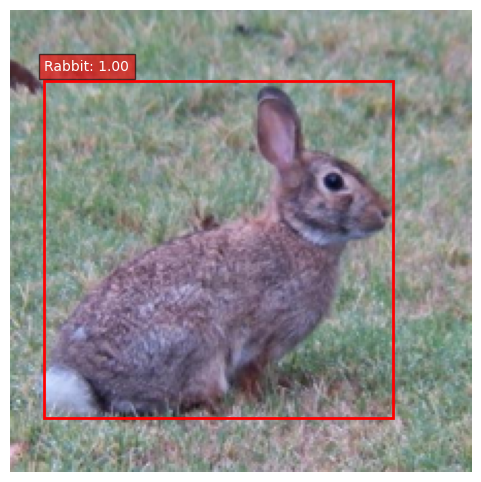

In [3]:
# Visualize the image
plot_image_with_boxes(image, target)

## 1.2 Define dataloaders and the target device

Set batch_size and num_workers to values suitable for you PC.

- `batch_size` affects how many images is in each batch

- `num_workers` affects how many subprocesses is used for data loading

In [4]:
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, num_workers=4, shuffle=False)

# Automatically sets device to cuda if cuda is available. Otherwise uses cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.3 Define training and validation loops

In [5]:
# Training loop
def train_epoch(loader, model, criterion, optimizer):
    # Set model to training mode
    model.train()
    
    # Define epoch loss
    epoch_loss = 0
    losses = []
    for images, targets in tqdm(loader):
        
        # Move images to device
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())

    # Return average loss 
    return losses

# Validation loop
def validate(loader, model, criterion):
    # Set model to validation mode
    model.eval()
    
    # Define epoch loss
    val_loss = 0
    
    # During validation we can skip gradient computation
    with torch.no_grad():
        for images, targets in loader:
            
            # Move images to device
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            
            # Optional plotting
            # plot_image_with_boxes(images[0].cpu(), outputs[0].cpu())

    # Return average loss 
    return val_loss / len(loader)

## 1.4 Define the model

If you are not that familiar with neural networks and do not know what forward pass means check out this [tutorial](https://www.geeksforgeeks.org/understanding-the-forward-function-output-in-pytorch/).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils.config as config

from torchvision.models import alexnet, resnet18, resnet50

class YOLOv1(nn.Module):
    def __init__(self, backbone_type="alexnet"):
        super().__init__()
        ##### Do not change. 
        # Load backbone
        if backbone_type == "alexnet":
            backbone = alexnet(weights="DEFAULT")
            out_channels = 256
        elif backbone_type == "resnet18":
            backbone = resnet18(weights="DEFAULT")
            out_channels = 512
        elif backbone_type == "resnet50":
            backbone = resnet50(weights="DEFAULT")
            out_channels = 2048
        else:
            raise ValueError('backbone_type should be alexnet, resnet18, or resnet50')

        # Freeze backbone weights
        backbone.requires_grad_(False)

        # Delete last two layers as they contain the classifier
        backbone = nn.Sequential(*list(backbone.children())[:-2])
        #####
        
        # Ensures that the output from any backbone is same size 
        # Resizes the output to (B, 1024, 6, 6)
        self.channels = 1024
        resize = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)), nn.Conv2d(out_channels, self.channels, kernel_size=1)
        )

        # put it together so you do not forget to resize anything
        self.backbone = nn.Sequential(backbone, resize)

        # Match output size
        self.detector = DetectionNet(self.channels)

    def forward(self, x):
        out = self.backbone(x)
        out = self.detector(out)  # Pass through detection network

        return out

class DetectionNet(nn.Module):
    """Network taking in the features from pretrained backbone and outputting the predictions."""

    def __init__(self, in_channels):
        super().__init__()
        
        # Define the detection head
        S, B, C = config.GRID_SIZE,config.N_BBOX, config.N_CLASSES
        self.conv_layers = nn.Sequential(
                    nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(512, 256, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(256, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(128, S * S * (B * 5 + C), kernel_size=1)  # Output layer
                )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], 7, 7, -1)  # Reshape to (B, S, S, B*5 + C)
        return x

## 1.5 Train the model

In [16]:
# Instantiate the model:
model = YOLOv1(backbone_type="alexnet")
model.to(device)

# define loss and optimizer
loss_fn = YOLOLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train
num_epochs = 12
losses = []
val_losses = []
for epoch in range(num_epochs):
    epoch_losses = train_epoch(train_loader, model, loss_fn, optimizer)
    val_loss = validate(valid_loader, model, loss_fn)

    train_loss = sum(epoch_losses) / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    losses.extend(epoch_losses)
    val_losses.append(val_loss)

100%|██████████| 15/15 [02:16<00:00,  9.10s/it]


Epoch 1/12, Train Loss: 5.4125, Val Loss: 2.7382


100%|██████████| 15/15 [02:15<00:00,  9.06s/it]


Epoch 2/12, Train Loss: 3.1674, Val Loss: 2.5803


100%|██████████| 15/15 [02:10<00:00,  8.71s/it]


Epoch 3/12, Train Loss: 2.6009, Val Loss: 2.1893


100%|██████████| 15/15 [01:57<00:00,  7.81s/it]


Epoch 4/12, Train Loss: 2.1974, Val Loss: 1.9605


100%|██████████| 15/15 [02:09<00:00,  8.64s/it]


Epoch 5/12, Train Loss: 1.8836, Val Loss: 1.8059


100%|██████████| 15/15 [02:12<00:00,  8.86s/it]


Epoch 6/12, Train Loss: 1.7148, Val Loss: 1.5742


100%|██████████| 15/15 [02:22<00:00,  9.49s/it]


Epoch 7/12, Train Loss: 1.6470, Val Loss: 1.5805


100%|██████████| 15/15 [02:03<00:00,  8.25s/it]


Epoch 8/12, Train Loss: 1.5687, Val Loss: 1.5152


100%|██████████| 15/15 [02:02<00:00,  8.19s/it]


Epoch 9/12, Train Loss: 1.4545, Val Loss: 1.4398


100%|██████████| 15/15 [01:55<00:00,  7.67s/it]


Epoch 10/12, Train Loss: 1.4476, Val Loss: 1.6254


100%|██████████| 15/15 [02:05<00:00,  8.34s/it]


Epoch 11/12, Train Loss: 1.3736, Val Loss: 1.3343


100%|██████████| 15/15 [02:15<00:00,  9.02s/it]


Epoch 12/12, Train Loss: 1.3608, Val Loss: 1.3542


### Plot losses

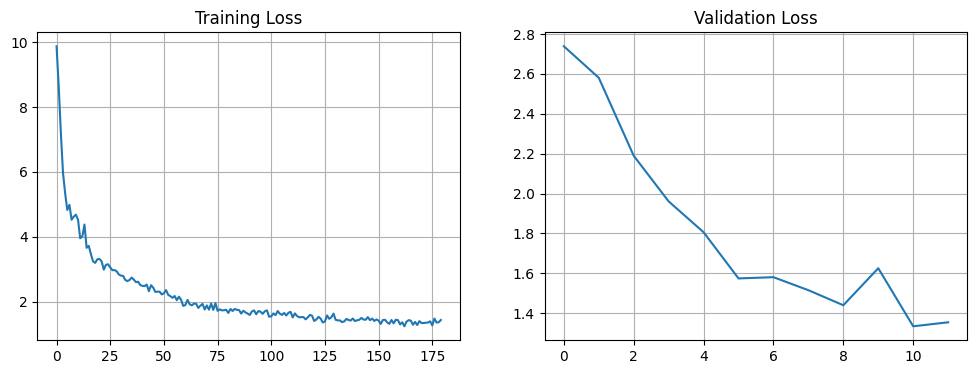

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Training Loss")
plt.grid()

plt.subplot(1,2,2)
plt.plot(val_losses)
plt.title("Validation Loss")
plt.grid()
plt.show()

## 1.6 Test the model

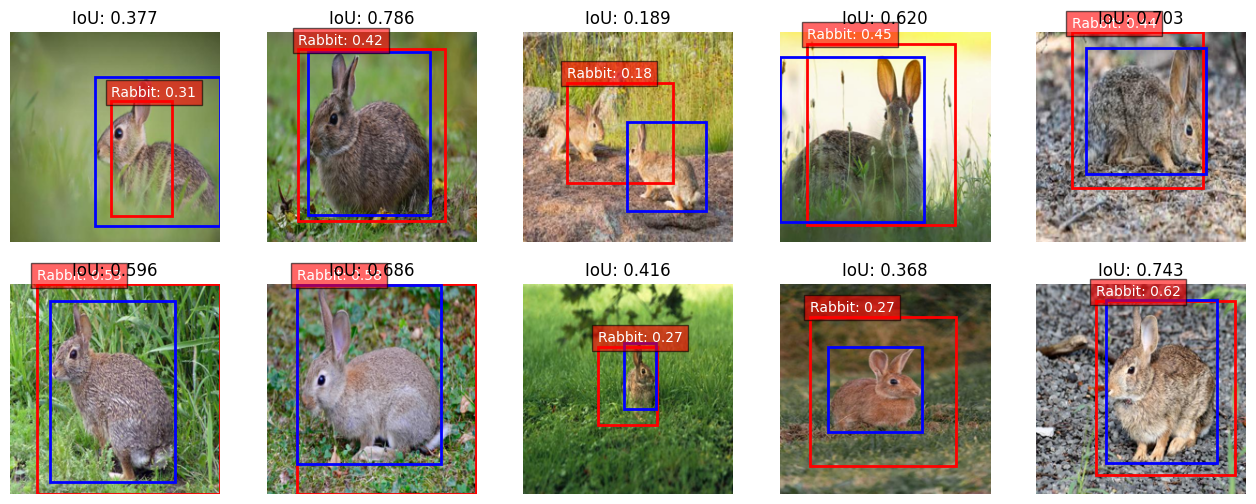

In [25]:
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(2, 5, figsize=(16, 6))
    
    iou_scores = []  # Store IoU scores
    # Flatten axes for easier indexing if multiple rows
    ax = ax.flatten()
    
    for idx, (image, target) in enumerate(test_dataset):
        # Get the tuple
        image_model = image.unsqueeze(0).to(device)
        pred = model(image_model).cpu().squeeze(0)
        pred_bbox, confidence = find_best_bbox(pred, image.shape[1])
        target_bbox, _ = find_best_bbox(target, image.shape[1])
        iou = compute_iou(pred_bbox, target_bbox)
        iou_scores.append(iou)
        # Unnormalize
        image = image*0.25 + 0.5
        
        ax[idx].imshow(image.permute(1, 2, 0).numpy())
        # Draw bounding box
        draw_bounding_box(ax[idx], pred_bbox, confidence)
        draw_bounding_box(ax[idx], target_bbox, confidence=None, color="blue")
        ax[idx].set_title(f"IoU: {iou:.3f}")
        ax[idx].axis("off")
    plt.show()

## Questions

### Does the code apply further augmentation to the training dataset?

Answer: Data augmentation is conditionally applied in this dataset class in the sense that if apply_transform=True, then data augmentation is applied when fetching images from the dataset and 
if apply_transform=False, then no augmentation occurs.

### What does the dataset return as a target? Explain the shape.

In [11]:
print(f"Data Target: {target}")
print(f"Data Target shape: {target.shape}")

Data Target: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.000

Answer: The dataset returns target values in the shape (7 x 7 (grid_size, grid_size), 6: [x, y, w, h, conf, class]) grid_size × grid_size represents the division of the image into a grid ( 7 × 7). Each grid cell contains six values: representing the bounding box coordinates (normalized), a confidence score indicating the presence of an object, and a class label. The target tensor from above shows how the data is stored for each row (7 x 6), the 6 values infomation of this image can be located at 4th row when the ouput is extended. In practice, we will aim to train the YOLO1 to predict similar output for the detection task

### How many parameters does your DetectionNet have?


In [20]:
# Model Instantialization with input channels = 1024 (from YOLOv1 backbone)
Dect_model = DetectionNet(in_channels=1024)

# Compute the number of parameters
num_params = sum(p.numel() for p in Dect_model.parameters())

print(f"Total number of parameters in DetectionNet is: {num_params}")

Total number of parameters in DetectionNet is: 6231974


In [22]:
from torchinfo import summary

summary(Dect_model, input_size=(1, 1024, 6, 6)) 

Layer (type:depth-idx)                   Output Shape              Param #
DetectionNet                             [1, 7, 7, 216]            --
├─Sequential: 1-1                        [1, 294, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 512, 6, 6]            4,719,104
│    └─ReLU: 2-2                         [1, 512, 6, 6]            --
│    └─Conv2d: 2-3                       [1, 256, 6, 6]            1,179,904
│    └─ReLU: 2-4                         [1, 256, 6, 6]            --
│    └─Conv2d: 2-5                       [1, 128, 6, 6]            295,040
│    └─ReLU: 2-6                         [1, 128, 6, 6]            --
│    └─Conv2d: 2-7                       [1, 294, 6, 6]            37,926
Total params: 6,231,974
Trainable params: 6,231,974
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 224.35
Input size (MB): 0.15
Forward/backward pass size (MB): 0.34
Params size (MB): 24.93
Estimated Total Size (MB): 25.42

### What is the shape of the output from the forward pass? Explain what each dimension represents.

In [31]:
# Define dummy input tensor simulating output from YOLOv1 backbone
batch_size = 5  # Batch size
in_channels = 1024  # Feature map channels from backbone
feature_map_size = 6  # Feature map size from backbone

#  Dummy input tensor
dummy_input = torch.randn(batch_size, in_channels, feature_map_size, feature_map_size)

# Instantiate the model
Dect_model = DetectionNet(in_channels=in_channels)

# Perform a forward pass to get output shape
output = Dect_model(dummy_input)

# Print the shape of the output
print("Output shape:", output.shape)

Output shape: torch.Size([5, 7, 7, 216])


The output shape consists of three main dimensions: Batch Size, representing the number of images processed in one batch; S × S grid ( 7 × 7 for YOLOv1); and ((294 (channels) * 6 * 6 (output grid))/49 =  216) (Prediction Per Grid Cell), which is used for estimating the bounding boxes dimension, confident and class scores. The first 5 probabilities out of the 216 is utilized for the estimation. This probability can vary based on the shape of the output layer of DetectionNet

In [47]:
for idx, (image, target) in enumerate(test_dataset):
    # Get the tuple
    image_model = image.unsqueeze(0).to(device)
    pred = model(image_model).cpu().squeeze(0)
    #chec_outputs = model(test_dataset[0])
    print(image.shape[1])
    break

224


The output for each image is of shape (7, 7, 216), containing bounding box predictions and class probabilities for each of the 49 grid cells. The first 4 probabilities are used to estimate   x, y relative to grid cell and w, h relative to image

### What is the average Intersection-over-Union (IoU) of the test set? Are there test images where IoU is poor? Why?


In [28]:
import numpy as np
# Computing average IoU
average_iou = np.mean(iou_scores)
print(f" Average IoU on Test Set: {average_iou:.3f}")

# Identify poor IoU cases
poor_iou_images = [i for i, iou in enumerate(iou_scores) if iou < 0.5]
print(f" Test images with poor IoU (< 0.5): {poor_iou_images}")

 Average IoU on Test Set: 0.548
 Test images with poor IoU (< 0.5): [0, 2, 7, 8]


The average IoU on test is 0.548, and some poor detection happned on image at index 1, 3, 8 and 9. From the prdiction plot on the test set, it was seen that the third image had the poorest dection beacause there were two rabbits in a single image and in general, the other predictions (1,8,9) were poor becuase of either larger or smaller boundinng box predicted. This could be attributed to the illumination condition of those images.

### How many epochs do you need to train to obtain good performance?

Answer: From the training gragh, it is evident that the loss of both the training and validation set do not decrease significantly after 5 epochs which shows that 5 epoch is an optimal number for good performance.


### Does the choice of backbone affect the performance? Train the network with one backbone, then try another, and compare results.
 

In [67]:
def acc_validator(model,test_dataset):
    model.eval()
    with torch.no_grad():
        iou_scores = []  # Store IoU scores

        for _, (image, target) in enumerate(test_dataset):
            # Get the tuple
            image_model = image.unsqueeze(0).to(device)
            pred = model(image_model).cpu().squeeze(0)
            pred_bbox, _ = find_best_bbox(pred, image.shape[1])
            target_bbox, _ = find_best_bbox(target, image.shape[1])
            iou = compute_iou(pred_bbox, target_bbox)
            iou_scores.append(iou)
        average_iou = np.mean(iou_scores)
    return average_iou
            
def compare_model():
    models = ["alexnet", "resnet18", "resnet50"]
    model_losses = []
    acc_model = []
    for model_name in models:
        # Instantiate the model:
        model = YOLOv1(backbone_type=model_name)
        model.to(device)

        # define loss and optimizer
        loss_fn = YOLOLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # train
        num_epochs = 3
        losses = []

        for epoch in range(num_epochs):
            epoch_losses = train_epoch(train_loader, model, loss_fn, optimizer)

            train_loss = sum(epoch_losses) / len(train_loader)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
            losses.extend(epoch_losses)
        model_losses.append(losses)
        acc_model.append(acc_validator(model,test_dataset))
    return model_losses, acc_model

def plot_acc_loss(n_name,loss,acc):
    # Create subplots
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

    for i, ax in enumerate(axes):
        ax.plot(loss[i], marker='o', linestyle='-', label=f"{n_name[i]} Loss")
        ax.set_title(f"{n_name[i]} - Acc: {acc[i]}%")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [69]:
l,a = compare_model()

100%|██████████| 15/15 [02:30<00:00, 10.03s/it]


Epoch 1/3, Train Loss: 5.9641


100%|██████████| 15/15 [02:10<00:00,  8.73s/it]


Epoch 2/3, Train Loss: 3.4721


100%|██████████| 15/15 [02:16<00:00,  9.08s/it]


Epoch 3/3, Train Loss: 2.6730


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:10<00:00, 4.28MB/s]
100%|██████████| 15/15 [03:58<00:00, 15.91s/it]


Epoch 1/3, Train Loss: 5.6230


100%|██████████| 15/15 [04:14<00:00, 16.95s/it]


Epoch 2/3, Train Loss: 3.2412


100%|██████████| 15/15 [04:23<00:00, 17.53s/it]


Epoch 3/3, Train Loss: 2.7456


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:21<00:00, 4.79MB/s]
100%|██████████| 15/15 [08:04<00:00, 32.29s/it]


Epoch 1/3, Train Loss: 7.2345


100%|██████████| 15/15 [08:11<00:00, 32.80s/it]


Epoch 2/3, Train Loss: 4.0152


100%|██████████| 15/15 [08:13<00:00, 32.89s/it]


Epoch 3/3, Train Loss: 3.0181


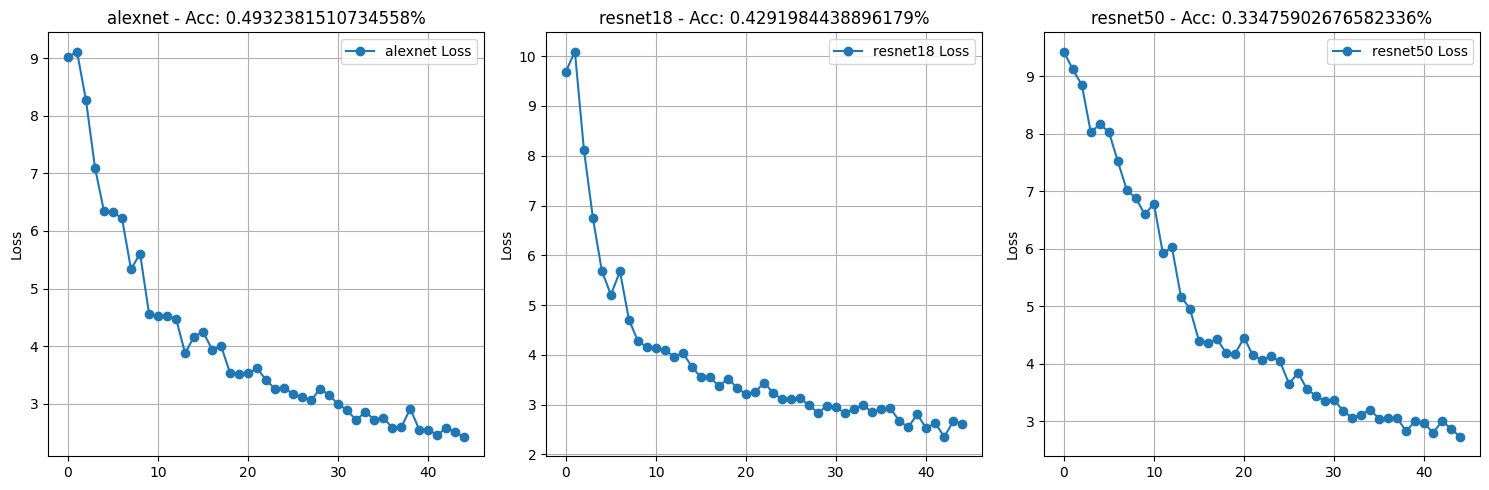

In [70]:
models = ["alexnet", "resnet18", "resnet50"]
plot_acc_loss(models,l,a)

Yes, the choice of backbone significantly impacts performance. From the graph above, it is evident that AlexNet achieved the highest performance for 3 epochs. ResNet18 followed with the second-highest performance, while ResNet50 had the lowest performance and required more training time. This indicates that ResNet50 is not the most suitable option for this task, as shown in the training results.

### How does grid size affect performance? In which types of tasks do we prefer smaller grid boxes, and when are larger grid boxes more suitable

Answer: The grid size (S × S) in YOLO affects object localization, detection accuracy, speed, and computational cost. Smaller grids (e.g., 14×14, 19×19) offer precise localization of small objects and can detect multiple objects in one cell but come with higher computational costs and a risk of overlapping bounding boxes. Larger grids (e.g., 7×7, 4×4) are faster, suitable for detecting large objects, and reduce false positives but struggle with small object localization.  Smaller grids work best for small or densely packed objects, while larger grids are ideal for detecting large objects efficiently, balancing speed and accuracy based on the object size, scene density, and computational resources.

### Try to understand the loss function. Could it be improved? If so, how?

The loss function follows the YOLO standard approach of defining loss function, thus incorporating localization loss (penalizing errors in bounding box coordinates and dimensions), confidence loss (ensuring accurate object presence prediction), and classification loss. In practice is computed as 
        total_loss = (self.lambda_coord * (loss_xy + loss_wh) +
                      loss_obj +
                      self.lambda_noobj * loss_noobj +
                      loss_class)
 where lambda_coord gives higer weight for object presence and lambda_noobj gives smaller weight to no-object confidence. In this task one ideal improvement is to remove classification loss since we only have one class to save computation time. Other improvements may be;  (1) Using log-space transformation instead of sqrt(w, h) to prevent instability; (2) Replacing MSE-based localization loss with IoU-based loss (GIoU or CIoU) for better box alignment; (3) Implementing Focal Loss instead of MSE for confidence and classification to handle class imbalance effectively; and (4) Normalizing the loss by the number of objects rather than batch size to prevent shrinking in sparse images. 